&lt;matplotlib.image.AxesImage at 0x7fafb0e19cd0&gt;

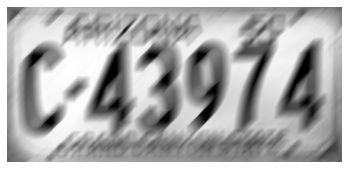

In [224]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from numpy import unravel_index
from scipy.signal import convolve2d as conv
from skimage.feature import canny
from skimage.transform import hough_line, rotate, radon
from skimage.filters import gaussian
from skimage import restoration, data, color

# Research on the blind restoration algorithm of motion-blurred image
# Review of Motion Blur Estimation Techniques

PSF_KERNEL_SIZE = 65

# Utility functions
def gen_psf_kernel(angle, length, kernel_size):
    # Rotate and shift to center
    angle = np.deg2rad(angle)
    rotation_m = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    translation_m = np.array([[np.round(kernel_size/2)], [np.round(kernel_size/2)]]) - np.matmul(rotation_m, np.array([[length/2], [0]]))
    tf_mat = np.hstack([rotation_m, translation_m])
    line = np.ones((1, length))
    psf_kernel = cv.warpAffine(line, tf_mat, (kernel_size, kernel_size))

    return psf_kernel

def blur_edge(img, kernel_size):
    blur_img = cv.copyMakeBorder(img, kernel_size, kernel_size, kernel_size, kernel_size, cv.BORDER_CONSTANT)
    blur_img = cv.GaussianBlur(blur_img, (kernel_size, kernel_size), -1)
    h, w = blur_img.shape
    blur_img = blur_img[kernel_size: h-kernel_size, kernel_size: w-kernel_size]
    return blur_img

img = color.rgb2gray(cv.imread('MotionBlur_LicensePlate.png'))
plt.axis('off')
plt.imshow(img, cmap='gray')




&lt;matplotlib.image.AxesImage at 0x7faff5e3a310&gt;

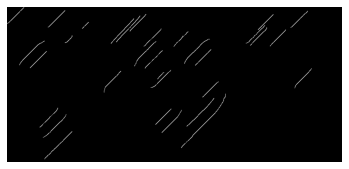

In [4]:
# Detect edges
edges = canny(img, low_threshold=0.2, high_threshold=0.4)
plt.axis('off')
plt.imshow(edges, cmap='gray')


Motion angle(degree) : 45.12534818941506


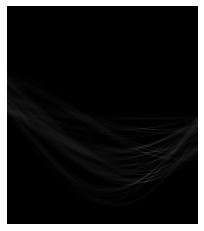

In [6]:
# Estimate motion angle using Hough TF
theta = np.linspace(-np.pi / 2, np.pi / 2, 360)
accumulator, angles, d = hough_line(edges, theta)
# Find angle of dominant line
_, dominant_theta_idx = unravel_index(accumulator.argmax(), accumulator.shape)
motion_angle = 90. - np.rad2deg(angles[dominant_theta_idx])
plt.axis('off')
plt.imshow(accumulator, cmap='gray', aspect=1/5)
print(f'Motion angle(degree) : {motion_angle}')

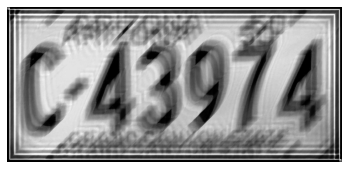

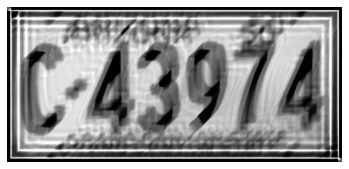

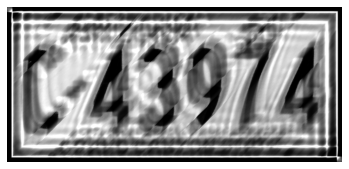

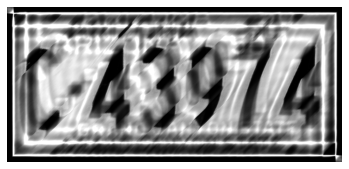

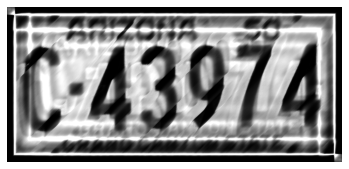

In [171]:
# Find appropriate lengths
lengths = [20, 30, 40, 50, 60]
for l in lengths:
    psf = gen_psf_kernel(-motion_angle, l, PSF_KERNEL_SIZE)
    res = restoration.richardson_lucy(img, psf)
    plt.figure()
    plt.axis('off')
    plt.imshow(res, cmap='gray')

&lt;matplotlib.image.AxesImage at 0x7fafb0be0040&gt;

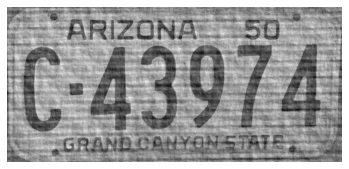

In [231]:
psf = gen_psf_kernel(-motion_angle, 64, PSF_KERNEL_SIZE)
recon_img, _ = restoration.unsupervised_wiener(img, psf)
plt.axis('off')
plt.imshow(recon_img, cmap='gray')
